# Assignment 1: Part 3

# P3. CIFAR10 image classification

**Task**

Design and implement a convolutional neural network for the CIFAR10 image classification task aiming to achieve a high test accuracy. Evaluate the classification accuracy by reporting top-1 and top-5 test error rates.

Including:
- plot the average loss 
- top-1 error rate 
- top-5 error rate per epoch versus the number of epochs for the training and the test dataset. 

Make sure to well describe and justify your network architecture design choices.

In [25]:
#Import Libraries
   
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
np.random.seed(1)
from datetime import datetime as dt
import datetime
from datetime import datetime

#Get the Data and Explore 

from keras.datasets import cifar10
(data_train, label_train), (data_test, label_test) = cifar10.load_data()

#Shape 10,000x32x32x3 
#Classes: 10
#Conv2D: [batch_size, height, width, channels]
#Batch purposes: [batch_size, 32, 32, 3]

#Explore shape of Data 
#print(data_train[0].shape)
data_height = 32
data_width = 32
channels = 3

#Find number of different classes in data 
n_classes = int(max(label_train) - min(label_train) + 1)
#print(n_classes)
class_min = int(min(label_train))



#Find shape of labels
print(data_train.shape)

print(len(data_train), len(data_test))


#Unpack label_train data to reduce dimensionality for one_hot transform
label_train_unpackall = np.array([])
for i in range(len(label_train)):
    label_train_unpackall = np.append(label_train_unpackall, label_train.item(i))
    
label_test_unpackall = np.array([])
for i in range(len(label_test)):
    label_test_unpackall = np.append(label_test_unpackall, label_test.item(i))
    
#Transform Labels to One_hot
with tf.Session() as sess: 
  label_train_all_onehot = tf.cast(tf.one_hot(label_train_unpackall, n_classes), tf.float32).eval()
  label_test_all_onehot = tf.cast(tf.one_hot(label_test_unpackall, n_classes), tf.float32).eval()
  
  label_train_all_onehot_2 = tf.one_hot(label_train , n_classes).eval()

 


(50000, 32, 32, 3)
50000 10000


In [0]:
len(data_train)%128

80

In [0]:
#Define Setup for Variables and Parameters  which are Independent of CNN Architecture 

#Reset Graph
tf.reset_default_graph()
  
#Set HyperParameters
cnn_minibatch_size = 128
cnn_learning_rate = 0.001 
cnn_total_n_epochs = 100
n_minibatches = int(len(data_train)/cnn_minibatch_size)


#Create Placeholders for Data
with tf.variable_scope('placeholders') as scope: 
    X = tf.placeholder(tf.float32, [50000, 32,32,3], name = "X")
    y = tf.placeholder(tf.float32, [50000, n_classes], name = "y")  # cnn_minibatch_size
    y_labels = tf.argmax(y, axis=1)  # From Lecture 4, Homework example 


#Create Placeholders for Train error  Data
with tf.variable_scope('placeholders') as scope: 
    X_train = tf.placeholder(tf.float32, [50000, 32,32,3], name = "X_train")
    y_train = tf.placeholder(tf.float32, [50000, n_classes], name = "y_train")  # cnn_minibatch_size
    y_labels_train = tf.argmax(y_train, axis=1)  # From Lecture 4, Homework example 


    #Create Placeholders for Test Data
with tf.variable_scope('placeholders') as scope: 
    X_test = tf.placeholder(tf.float32, [10000, 32,32,3], name = "X_test")
    y_test = tf.placeholder(tf.float32, [10000, n_classes], name = "y_test")  # cnn_minibatch_size
    y_labels_test = tf.argmax(y_test, axis=1)  # From Lecture 4, Homework example 

    
#Define Dataset shuffle 

data_set = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(n_minibatches*cnn_minibatch_size, reshuffle_each_iteration = False).batch(cnn_minibatch_size)

iterator = data_set.make_initializable_iterator()

x_batch, y_batch = iterator.get_next()


#Define Dataset batch handling for training set error

data_set_train = tf.data.Dataset.from_tensor_slices((X_train, y_train, y_labels_train)).shuffle(n_minibatches*cnn_minibatch_size, reshuffle_each_iteration = False).batch(cnn_minibatch_size) # #shuffle(n_minibatches*cnn_minibatch_size, reshuffle_each_iteration = False)
iterator_train = data_set_train.make_initializable_iterator()
x_batch_train, y_batch_train, y_batch_labels_train = iterator_train.get_next()



#Define Dataset batch handling for test set

data_set_test = tf.data.Dataset.from_tensor_slices((X_test, y_test, y_labels_test)).batch(cnn_minibatch_size)  #shuffle
iterator_test = data_set_test.make_initializable_iterator()
x_batch_test, y_batch_test, y_batch_labels_test = iterator_test.get_next()


#Define Output Variations

outputs = deeper_variation_CNN1(x_batch)     #output_string
outputs_train = deeper_variation_CNN1(x_batch_train)  
outputs_test = deeper_variation_CNN1(x_batch_test)
  
#Define Loss Function    
with tf.name_scope("loss") as scope: 
  loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_batch, logits = outputs, name = "cross_entropy_loss"))
  loss_sum_v = tf.Variable(0.0, dtype = tf.float32)
  loss_tozero = loss_sum_v.assign(0.0)
  loss_add = loss_sum_v.assign_add(loss)        
    
  loss_average = tf.divide(loss_sum_v, tf.constant(128.0, dtype= tf.float32)) 

#Define Optimisers

#Mini-batch gradient descent 
optimiser_gd_cnn=tf.train.GradientDescentOptimizer(learning_rate=cnn_learning_rate) 

#Mini-batch AdaGrad (Géron, 2017 p.300)
   
optimiser_ag_cnn = tf.train.AdagradOptimizer(learning_rate =cnn_learning_rate)  

#Mini-batch gradient descent with Nesterov´s momentum (Géron, 2017 p.299)

optimiser_n_cnn = tf.train.MomentumOptimizer(learning_rate =cnn_learning_rate , momentum = 0.9, use_nesterov = True) 
    
#Mini-batch Adam (Géron, 2017 p.302)
    
optimiser_adm_cnn = tf.train.AdamOptimizer(learning_rate =cnn_learning_rate ) 
    
    
# Error rate code based on Evaluation in Géron (2017, p.271)
    
with tf.name_scope("Top_1_Error"):
    top1_errors = (tf.subtract(tf.constant(1, dtype= tf.int32), tf.cast(tf.nn.in_top_k(outputs_train,tf.cast(y_batch_labels_train , tf.int32), 1),tf.int32)))  #tf.arg_max(, dimension = 1)
    top1_error_rate = tf.reduce_mean(tf.cast(top1_errors, tf.float32))
        
with tf.name_scope("Top_5_Error"):
  top5_errors = tf.subtract(tf.constant(1), tf.cast(tf.nn.in_top_k(outputs, tf.cast(y_batch_labels_train , tf.int32), 5), tf.int32)) # , tf.arg_max dimension = 1)
  top5_error_rate = tf.reduce_mean(tf.cast(top5_errors, tf.float32))

with tf.name_scope("Top_1_Error_test"):
    top1_errors_test = (tf.subtract(tf.constant(1, dtype= tf.int32), tf.cast(tf.nn.in_top_k(outputs_test,tf.cast(y_batch_labels_test , tf.int32), 1),tf.int32)))  #tf.arg_max(, dimension = 1)
    top1_error_rate_test = tf.reduce_mean(tf.cast(top1_errors, tf.float32))
        
with tf.name_scope("Top_5_Error_test"):
  top5_errors_test = tf.subtract(tf.constant(1), tf.cast(tf.nn.in_top_k(outputs_test, tf.cast(y_batch_labels_test , tf.int32), 5), tf.int32)) # , tf.arg_max dimension = 1)
  top5_error_rate_test = tf.reduce_mean(tf.cast(top5_errors, tf.float32))          
    
   
#Define training error sum variables
top1_train_sum = tf.Variable(0.0, dtype= tf.float32)
top5_train_sum = tf.Variable(0.0, dtype= tf.float32)
top1_test_sum = tf.Variable(0.0, dtype= tf.float32)
top5_test_sum = tf.Variable(0.0, dtype= tf.float32)
           
#Define functions setting error sum variables to zero
top1_train_sum_tozero = top1_train_sum.assign(0.0)
top5_train_sum_tozero = top5_train_sum.assign(0.0)
top1_test_sum_tozero = top1_test_sum.assign(0.0)
top5_test_sum_tozero = top5_test_sum.assign(0.0)
            
#Define Functions adding the current error to sum variable
top1_train_sum_add = top1_train_sum.assign_add(top1_error_rate)
top5_train_sum_add = top5_train_sum.assign_add(top5_error_rate)
top1_test_sum_add = top1_test_sum.assign_add(top1_error_rate_test)
top5_test_sum_add = top5_test_sum.assign_add(top5_error_rate_test)
            
            
#Define function averaging error rates per epoch
top1_train_epoch_avg = tf.divide(top1_train_sum, tf.constant(128.0, dtype= tf.float32))
top5_train_epoch_avg = tf.divide(top5_train_sum, tf.constant(128.0, dtype= tf.float32))
top1_test_epoch_avg =  tf.divide(top1_test_sum, tf.constant(128.0, dtype= tf.float32))
top5_test_epoch_avg =  tf.divide(top5_test_sum, tf.constant(128.0, dtype= tf.float32))


#Define function plotting avg loss per epoch 
def plot_avg_epoch_loss(avg_loss_epoch_list):
  plt.plot(avg_loss_epoch_list)
  plt.xlabel("Epoch")
  plt.ylabel("Average Epoch loss")
  plt.legend()
  plt.show() 
     
  #Define Error plot function 
    
def plot_train_test_error(error_train, error_test, title): 
  plt.plot(error_train, label = 'Train error' )
  plt.plot(error_test, label = 'Test Error')
  plt.ylabel('Error rate')
  plt.xlabel('Epoch')
  plt.title(title)
  plt.legend()
  plt.show()
    

#Save all parametres to disk
saver = tf.train.Saver()

#Top 1 error rate 

#Top 5 error rate 



In [0]:
#Define Default CNN Training Function 
def CNN_arch_train():
    
    with tf.Session() as sess: 

      
        #Define training operation 
        #Using Adam Optimiser with Default value as suggested by Géron (2017 p.303)

        optimiser=optimiser_adm_cnn

        cnn_train_op=optimiser.minimize(loss)
        
        
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        tf.initialize_all_variables().run()
        
        #cnn_loss_list = np.array([])
        cnn_avg_loss_epoch_list = np.array([])
        cnn_top1_error_train = np.array([])
        cnn_top5_error_train = np.array([])
        cnn_top1_error_test = np.array([])
        cnn_top5_error_test = np.array([])
       

        #Define array for shuffling in each epoch 
        reference_array = tf.range(n_minibatches)

        #Train CNN by iterating through epochs
        for epoch in range(0,100): 
            
            if (epoch+1)%10==0:
              print("starting epoch", epoch)
            epoch_start_time = dt.now()
            

            #Reset all Error estimates to zero, start of batch 
            sess.run(iterator.initializer, feed_dict = {X:data_train ,y:label_train_all_onehot}) 
            

            #ReSet Loss variable to zero 
            sess.run([loss_tozero, top1_train_sum_tozero, top5_train_sum_tozero, top1_test_sum_tozero, top5_test_sum_tozero])
            
            # Iterate through first 50 mini-batches for one epoch training
            for batch in range (0,50):

                #Run the session on the next minibatch -  
                _, l, la = sess.run([ cnn_train_op, loss, loss_add])  # feed_dict= {X: data_train_current , y: label_train_current})  #[data_index: data_index+cnn_minibatch_size]
                


            #Add Avg Epoch loss to list
            avg_epoch_loss = loss_average.eval()
            cnn_avg_loss_epoch_list = np.append(cnn_avg_loss_epoch_list, avg_epoch_loss) #(sum(cnn_loss_list[0+cnn_minibatch_size*epoch:cnn_minibatch_size+cnn_minibatch_size*epoch]))/cnn_minibatch_size)
            
            if (epoch+1)%10==0:
              print("epoch loss", avg_epoch_loss)

           
            #Initialize Iterator with training data for error evaluation 
            sess.run(iterator_train.initializer, feed_dict = {X_train: data_train , y_train:label_train_all_onehot})  

            #Evaluate on Training Set
            for batch_n in range(0,100): 

              #Evaluate training and test error per batch              
              top1_train_batch, top5_train_batch, t1_tr , t2_tr = sess.run([top1_error_rate, top5_error_rate, top1_train_sum_add, top5_train_sum_add]) # feed_dict = {X: data_train , y: label_train_all_onehot})
                            
            #Initialize Iterator with test data for error evaluation 
            sess.run(iterator_test.initializer, feed_dict = {X_test: data_test , y_test: label_test_all_onehot})  
            #print("initalized test")
             
            #Evaluate on Test set   
            for batch_nn in range(0,78): 

              top1_test_batch, top5_test_batch, t1_te, t2_te = sess.run([top1_error_rate_test, top1_error_rate_test, top1_test_sum_add, top5_test_sum_add ]) #, feed_dict = {X_test: data_test , y_test: label_test_all_onehot})

            #Evaluate the error rate variables at the end of epoch
            cnn_top1_error_train_epoch = top1_train_epoch_avg.eval()
            cnn_top5_error_train_epoch = top5_train_epoch_avg.eval()
            cnn_top1_error_test_epoch =  top1_test_epoch_avg.eval()
            cnn_top5_error_test_epoch =  top5_test_epoch_avg.eval()          
            
            cnn_top1_error_train = np.append(cnn_top1_error_train , cnn_top1_error_train_epoch)
            cnn_top5_error_train = np.append(cnn_top5_error_train, cnn_top5_error_train_epoch)
            cnn_top1_error_test = np.append(cnn_top1_error_test,  cnn_top1_error_test_epoch)
            cnn_top5_error_test = np.append(cnn_top5_error_test, cnn_top5_error_test_epoch)
            

            if (epoch+1) %10 == 0:
              print("Errors Epoch nr ", epoch, "Top 1 error: train ", cnn_top1_error_train_epoch, "test",cnn_top1_error_test_epoch,'\n', 
                 "Top 5 error: train", cnn_top5_error_train_epoch, "test",cnn_top5_error_test_epoch)
            
              
              #Take the time of each epoch 
              epoch_endtime = str(dt.now())
              #epoch_duration = str(datetime.timedelta(epoch_start_time, epoch_endtime))
              print("ended epoch:", epoch, "endtime", epoch_endtime ) # "duration:", epoch_duration)
              
              save_string ="/"+str(epoch)+"cnn1.ckpt"
              save_patch = saver.save(sess, save_string)
              
        #Plot top 1 and top 5 error rates
        try: 
          plot_train_test_error(cnn_top1_error_train, cnn_top1_error_test, "Top 1 error, train vs test")
          plot_train_test_error(cnn_top5_error_train, cnn_top5_error_test, "Top 5 error, train vs test")

        except: 
          print("Error plots unsuccessfull")
          
        #Plot Avg Epoch Loss
        try:
          plot_avg_epoch_loss(cnn_avg_loss_epoch_list)
        
        except: 
          print("Loss plots unsuccessfull")
        
        #Save model 
        try:
          save_patch = saver.save(sess, "/CNN.ckpt")
        except:
          print("Save unsuccessfull")
        
    return cnn_avg_loss_epoch_list, cnn_top1_error_train, cnn_top5_error_train, cnn_top1_error_test, cnn_top5_error_test
        



## CNN Architecture 1: Deeper Variation of Basic CNN

**Design Considerations**

The first method explored is a deeper variation over the basic CNN architecture from part 2. Several well performing architectures including AlexNet and GoogleNet feature more than three convolution layers and more than one hidden dense layer for the output (Geron, 2017 p.371-378). The  deeper variation of the Basic CNN therefore adds one more convolutional layer and one more hidden layer. It also explores increasing filter depths in order to try to capture more features from the images. 


---
**CNN Architecture 1**

---
| Layers | Type | Maps| Size | Kernel Size | Stride | Activation |
| --- | --- | --- | --- |  --- |  --- | --- |
| Out | Fully connected | - | 10 | - | - | - |
| Hidden 2 | Fully connected | - | 1000 | - | - | ReLU |
| Hidden 1 | Fully connected | - | 1000 | - | - | ReLU |
| Conv4_maxpool | Maxpool | 128| 32x32 | 2x2 | 2 | - |
| Conv4_conv | Convolution | 128| 32x32 | 5x5 | 1 | ReLU |
| Conv3_maxpool | Maxpool | 64| 32x32 | 2x2 | 2 | - |
| Conv3_conv | Convolution | 64| 32x32 | 5x5 | 1 | ReLU |
| Conv2_maxpool | Maxpool | 32| 32x32 | 2x2 | 2 | - |
| Conv2_conv | Convolution | 32| 32x32 | 5x5 | 1 | ReLU |
| Conv1_maxpool | Maxpool | 32| 32x32 | 2x2 | 2 | - |
| Conv1_conv | Convolution | 32| 32x32 | 5x5 | 1 | ReLU |




In [0]:

# Deeper variation of Convolutional Neural Network 
def deeper_variation_CNN1(data_train):  #cnn_minibatch_size

    
    with tf.variable_scope('full_cnn', reuse = tf.AUTO_REUSE):
        
        
        #Convolutional layer 1   - channels!
        with tf.name_scope("Convolutional_layer_1") as scope: 
            conv_layer1_conv_sublayer = tf.layers.conv2d(data_train, filters = 32, kernel_size = 5 , strides = 1, padding = "same", activation = tf.nn.relu, name = "conv1")
            conv_layer1_maxp_sublayer = tf.layers.max_pooling2d(inputs = conv_layer1_conv_sublayer, pool_size = [2,2] , strides = 2, name = "maxpool1")

        #Convolutional layer 2 -Same, but with conv1 input
        with tf.name_scope("Convolutional_layer_2") as scope: 
            conv_layer2_conv_sublayer = tf.layers.conv2d(conv_layer1_maxp_sublayer, filters = 32, kernel_size = 5, strides = 1,padding = "same",  activation = tf.nn.relu, name = "conv2")
            conv_layer2_maxp_sublayer = tf.layers.max_pooling2d(inputs = conv_layer2_conv_sublayer, pool_size = [2,2] , strides = 2, name = "maxpool2")

        #Convolutional layer 3
        with tf.name_scope("Convolutional_layer_3") as scope: 
            conv_layer3_conv_sublayer = tf.layers.conv2d(conv_layer2_maxp_sublayer, filters = 64, kernel_size = 5 , strides = 1,padding = "same",  activation = tf.nn.relu, name = "conv3")
            conv_layer3_maxp_sublayer = tf.layers.max_pooling2d(inputs = conv_layer3_conv_sublayer, pool_size = [2,2] , strides = 2, name = "maxpool3")

        #Convolutional layer 4
        with tf.name_scope("Convolutional_layer_4") as scope: 
            conv_layer4_conv_sublayer = tf.layers.conv2d(conv_layer3_maxp_sublayer, filters = 128, kernel_size = 5 , strides = 1,padding = "same",  activation = tf.nn.relu, name = "conv4")
            conv_layer4_maxp_sublayer = tf.layers.max_pooling2d(inputs = conv_layer4_conv_sublayer, pool_size = [2,2] , strides = 2, name = "maxpool4")


        #Flattening inputs for dense layer  - [batch_size, 32,32,3]
        conv_flat = tf.reshape(conv_layer4_maxp_sublayer, [-1, 128*2*2 ], name = "flattening")
        
        with tf.name_scope("Hidden_Layers") as scope: 
          #Hidden Layer 1: Hidden fully connected layer of 1000 units
          hidden_layer_1 = tf.layers.dense( inputs =  conv_flat, units = 1024, activation = tf.nn.relu, name = "hidden_layer_1")

          #Hidden Layer 1: Hidden fully connected layer of 1000 units
          hidden_layer_2 = tf.layers.dense( inputs =  hidden_layer_1, units = 1024, activation = tf.nn.relu, name = "hidden_layer_2")
 
        #Output Layer 
        with tf.name_scope("Outputs") as scope: 
            outputs = tf.layers.dense(inputs = hidden_layer_2, units = n_classes, activation = None, name = "outputs")

    return outputs 





starting epoch 9
epoch loss 0.51229084
Errors Epoch nr  9 Top 1 error: train  0.37200928 test 0.28460693 
 Top 5 error: train 0.3892212 test 0.305542
ended epoch: 9 endtime 2019-02-27 12:35:48.025963
starting epoch 19
epoch loss 0.4138765
Errors Epoch nr  19 Top 1 error: train  0.28900146 test 0.22229004 
 Top 5 error: train 0.39013672 test 0.30236816
ended epoch: 19 endtime 2019-02-27 12:36:43.300942
starting epoch 29
epoch loss 0.37983054
Errors Epoch nr  29 Top 1 error: train  0.24346924 test 0.19042969 
 Top 5 error: train 0.3909912 test 0.31072998
ended epoch: 29 endtime 2019-02-27 12:37:38.831410
starting epoch 39
epoch loss 0.31205347
Errors Epoch nr  39 Top 1 error: train  0.19989014 test 0.15136719 
 Top 5 error: train 0.3920288 test 0.309021
ended epoch: 39 endtime 2019-02-27 12:38:33.702229
starting epoch 49
epoch loss 0.25874427
Errors Epoch nr  49 Top 1 error: train  0.18658447 test 0.14257812 
 Top 5 error: train 0.39337158 test 0.30664062
ended epoch: 49 endtime 2019-02-

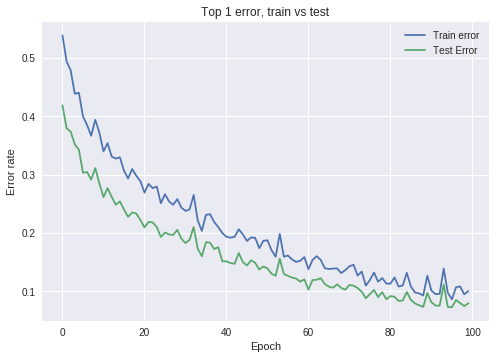

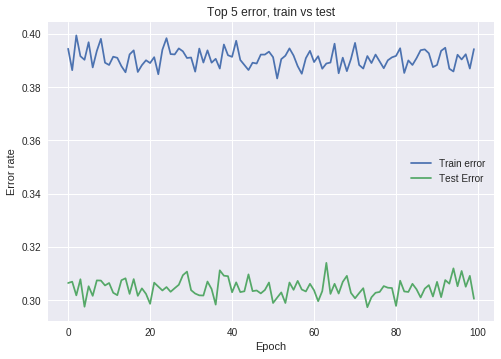

No handles with labels found to put in legend.


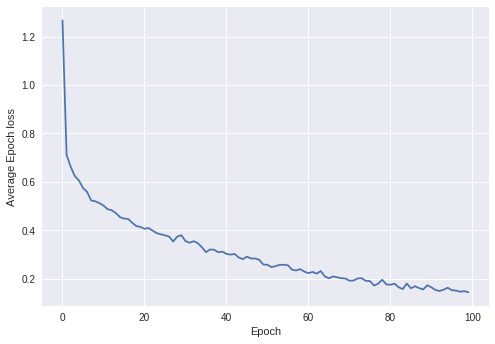

In [29]:
#Train CNN1 model 

cnn1_avg_loss, cnn1_top1_error_train, cnn1_top5_error_train, cnn1_top1_error_test, cnn1_top5_error_test = CNN_arch_train()




## CNN Architecture 2: Variation Inspired by AlexNet

**Design Considerations**

The second CNN architectures explored was a variation of the basic CNN inspired by AlexNet (Geron, 2017 p.373). After two convolutional layers of increasing map size (C1<C2) with a maxpool layer in between, the AlexNet CNN architecture stacks two identical convolutional layers of larger map size (C2< C3 = C4), followed directly by a convolutional layer with smaller map size (C4> C5). Using this analogy of increasing, then decreasing map sizes, as well as three convolutional layers directly following each other, CNN Architecture 2 is designed as follows. The map sizes are (C1 (32)< C2(64)  <C3(128) <C4(192) = C5(192) > C6(128). The reason for three rather than two consequtive layers followed by a maxpool, was to allow the sequential layers C4, C5 to have a greater map depth than in the basic CNN from part P2, reaching the depth of deepest map of each of the single GPU splits in AlexNet (Geron, 2017 p.373; Lectures week 4). The hypothesis behind this test is that these deeper filter maps will allow the CNN 2 to recognize a greater number of patterns. 



---
**CNN Architecture 2**

---
| Layers | Type | Maps| Size | Kernel Size | Stride | Activation |
| --- | --- | --- | --- |  --- |  --- | --- |
| Out | Fully connected | - | 10 | - | - | - |
| Hidden 2 | Fully connected | - | 1000 | - | - | ReLU |
| Hidden 1 | Fully connected | - | 1000 | - | - | ReLU |
| Conv6_conv | Convolution | 128| 32x32 | 5x5 | 1 | ReLU |
| Conv5_conv | Convolution | 192| 32x32 | 5x5 | 1 | ReLU |
| Conv4_conv | Convolution | 192| 32x32 | 5x5 | 1 | ReLU |
| Conv3_maxpool | Maxpool | 128| 32x32 | 2x2 | 2 | - |
| Conv3_conv | Convolution | 128| 32x32 | 5x5 | 1 | ReLU |
| Conv2_maxpool | Maxpool | 64| 32x32 | 2x2 | 2 | - |
| Conv2_conv | Convolution | 64| 32x32 | 5x5 | 1 | ReLU |
| Conv1_maxpool | Maxpool | 32| 32x32 | 2x2 | 2 | - |
| Conv1_conv | Convolution | 32| 32x32 | 5x5 | 1 | ReLU |



In [30]:
#Import Libraries

   
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
np.random.seed(1)
from datetime import datetime as dt
import datetime
from datetime import datetime

#Get the Data and Explore 

from keras.datasets import cifar10
(data_train, label_train), (data_test, label_test) = cifar10.load_data()

#Shape 10,000x32x32x3 
#Classes: 10
#Conv2D: [batch_size, height, width, channels]
#Batch purposes: [batch_size, 32, 32, 3]

#Explore shape of Data 
#print(data_train[0].shape)
data_height = 32
data_width = 32
channels = 3

#def default_CNN_setup():  #cnn_specific_outputs cnn_model
#Reset Graph
tf.reset_default_graph()

#Find number of different classes in data 
n_classes = int(max(label_train) - min(label_train) + 1)
#print(n_classes)
class_min = int(min(label_train))

#Find shape of labels
print(data_train.shape)

print(len(data_train), len(data_test))
#print(label_train[0:10])

#Unpack label_train data to reduce dimensionality for one_hot transform
label_train_unpackall = np.array([])
for i in range(len(label_train)):
    label_train_unpackall = np.append(label_train_unpackall, label_train.item(i))
    
label_test_unpackall = np.array([])
for i in range(len(label_test)):
    label_test_unpackall = np.append(label_test_unpackall, label_test.item(i))
    
    #if i %10000 == 0 :
    #    print(i)
    
with tf.Session() as sess: 
  label_train_all_onehot = tf.cast(tf.one_hot(label_train_unpackall, n_classes), tf.float32).eval()
  label_test_all_onehot = tf.cast(tf.one_hot(label_test_unpackall, n_classes), tf.float32).eval()
  
  label_train_all_onehot_2 = tf.one_hot(label_train , n_classes).eval()

  
#print(len(label_train_unpackall))

#Transform Labels to one hot
#label_train_onehot_all = tf.one_hot(label_train_unpackall, n_classes)


(50000, 32, 32, 3)
50000 10000


In [0]:
# Simple variation of Convolutional Neural Network 
def alexnet_variation_CNN2(data_train):  #cnn_minibatch_size

    
    with tf.variable_scope('full_cnn', reuse = tf.AUTO_REUSE):
        
        
        #Conv1:Convolutional layer 1   - 
        with tf.name_scope("Convolutional_layer_1") as scope: 
            conv_layer1_conv_sublayer = tf.layers.conv2d(data_train, filters = 32, kernel_size = 5 , strides = 1, padding = "same", activation = tf.nn.relu, name = "conv1")
            conv_layer1_maxp_sublayer = tf.layers.max_pooling2d(inputs = conv_layer1_conv_sublayer, pool_size = [2,2] , strides = 2, name = "maxpool1")

        #Conv2: Convolutional layer 2
        with tf.name_scope("Convolutional_layer_2") as scope: 
            conv_layer2_conv_sublayer = tf.layers.conv2d(conv_layer1_maxp_sublayer, filters = 64, kernel_size = 5 , strides = 1,padding = "same",  activation = tf.nn.relu, name = "conv2")
            conv_layer2_maxp_sublayer = tf.layers.max_pooling2d(inputs = conv_layer2_conv_sublayer, pool_size = [2,2] , strides = 2, name = "maxpool2")

        #Conv3: Convolutional layer 3, C3
        with tf.name_scope("Convolutional_layer_2") as scope: 
            conv_layer3_conv_sublayer = tf.layers.conv2d(conv_layer2_maxp_sublayer, filters = 128, kernel_size = 5 , strides = 1,padding = "same",  activation = tf.nn.relu, name = "conv3")
            conv_layer3_maxp_sublayer = tf.layers.max_pooling2d(inputs = conv_layer3_conv_sublayer, pool_size = [2,2] , strides = 2, name = "maxpool3")

        #Conv4, C5, C6: Sequential Convolutional Layers
        with tf.name_scope("Sequential_convolutional_layers") as scope: 
            conv_layer4_conv_sublayer = tf.layers.conv2d(conv_layer3_maxp_sublayer, filters = 192, kernel_size = 5 , strides = 1,padding = "same",  activation = tf.nn.relu, name = "conv4")
            conv_layer5_conv_sublayer = tf.layers.conv2d(conv_layer4_conv_sublayer, filters = 192, kernel_size = 5 , strides = 1,padding = "same",  activation = tf.nn.relu, name = "conv5")
            conv_layer6_conv_sublayer = tf.layers.conv2d(conv_layer5_conv_sublayer, filters = 128, kernel_size = 5 , strides = 1,padding = "same",  activation = tf.nn.relu, name = "conv6")

        #Flattening inputs for dense layer  - [batch_size, 32,32,3]
        conv_flat = tf.reshape(conv_layer6_conv_sublayer, [-1, 128*4*4 ], name = "flattening")
        
        with tf.name_scope("Hidden_Layers") as scope: 
          #Hidden Layer 1: Hidden fully connected layer of 1000 units
          hidden_layer_1 = tf.layers.dense( inputs =  conv_flat, units = 1024, activation = tf.nn.relu, name = "hidden_layer_1")

          #Hidden Layer 1: Hidden fully connected layer of 1000 units
          hidden_layer_2 = tf.layers.dense( inputs =  conv_flat, units = 1024, activation = tf.nn.relu, name = "hidden_layer_2")
 
        #Output Layer 
        with tf.name_scope("Outputs") as scope: 
            outputs = tf.layers.dense(inputs = hidden_layer_2, units = n_classes, activation = None, name = "outputs")

    return outputs 


In [0]:
#Define Setup for Variables and Parameters  which are Independent of CNN Architecture 


  
#Set HyperParameters
cnn_minibatch_size = 128
cnn_learning_rate = 0.001 
cnn_total_n_epochs = 100

n_minibatches = int(len(data_train)/cnn_minibatch_size)


#Create Placeholders for Data
with tf.variable_scope('placeholders') as scope: 
    X = tf.placeholder(tf.float32, [50000, 32,32,3], name = "X")
    y = tf.placeholder(tf.float32, [50000, n_classes], name = "y")  # cnn_minibatch_size
    y_labels = tf.argmax(y, axis=1)  # From Lecture 4, Homework example 


#Create Placeholders for Train error  Data
with tf.variable_scope('placeholders') as scope: 
    X_train = tf.placeholder(tf.float32, [50000, 32,32,3], name = "X_train")
    y_train = tf.placeholder(tf.float32, [50000, n_classes], name = "y_train")  # cnn_minibatch_size
    y_labels_train = tf.argmax(y_train, axis=1)  # From Lecture 4, Homework example 


    #Create Placeholders for Test Data
with tf.variable_scope('placeholders') as scope: 
    X_test = tf.placeholder(tf.float32, [10000, 32,32,3], name = "X_test")
    y_test = tf.placeholder(tf.float32, [10000, n_classes], name = "y_test")  # cnn_minibatch_size
    y_labels_test = tf.argmax(y_test, axis=1)  # From Lecture 4, Homework example 

    
#Define Dataset shuffle 

data_set = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(n_minibatches*cnn_minibatch_size, reshuffle_each_iteration = False).batch(cnn_minibatch_size)

iterator = data_set.make_initializable_iterator()

x_batch, y_batch = iterator.get_next()


#Define Dataset batch handling for training set error

data_set_train = tf.data.Dataset.from_tensor_slices((X_train, y_train, y_labels_train)).shuffle(n_minibatches*cnn_minibatch_size, reshuffle_each_iteration = False).batch(cnn_minibatch_size) # #shuffle(n_minibatches*cnn_minibatch_size, reshuffle_each_iteration = False)
iterator_train = data_set_train.make_initializable_iterator()
x_batch_train, y_batch_train, y_batch_labels_train = iterator_train.get_next()



#Define Dataset batch handling for test set

data_set_test = tf.data.Dataset.from_tensor_slices((X_test, y_test, y_labels_test)).batch(cnn_minibatch_size)  #shuffle
iterator_test = data_set_test.make_initializable_iterator()
x_batch_test, y_batch_test, y_batch_labels_test = iterator_test.get_next()


#Define Outputs 

outputs = alexnet_variation_CNN2(x_batch)     #output_string
outputs_train = alexnet_variation_CNN2(x_batch_train)  
outputs_test = alexnet_variation_CNN2(x_batch_test)


  
#Define Loss Function    
with tf.name_scope("loss") as scope: 
  loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_batch, logits = outputs, name = "cross_entropy_loss"))
  loss_sum_v = tf.Variable(0.0, dtype = tf.float32)
  loss_tozero = loss_sum_v.assign(0.0)
  loss_add = loss_sum_v.assign_add(loss)        
    
  loss_average = tf.divide(loss_sum_v, tf.constant(128.0, dtype= tf.float32)) 

#Define Optimisers

#Mini-batch gradient descent 
optimiser_gd_cnn=tf.train.GradientDescentOptimizer(learning_rate=cnn_learning_rate) 

#Mini-batch AdaGrad (Géron, 2017 p.300)
   
optimiser_ag_cnn = tf.train.AdagradOptimizer(learning_rate =cnn_learning_rate)  

#Mini-batch gradient descent with Nesterov´s momentum (Géron, 2017 p.299)

optimiser_n_cnn = tf.train.MomentumOptimizer(learning_rate =cnn_learning_rate , momentum = 0.9, use_nesterov = True) 
    
#Mini-batch Adam (Géron, 2017 p.302)
    
optimiser_adm_cnn = tf.train.AdamOptimizer(learning_rate =cnn_learning_rate ) 
    
    
# Error rate code based on Evaluation in Géron (2017, p.271)
    
with tf.name_scope("Top_1_Error"):
    top1_errors = (tf.subtract(tf.constant(1, dtype= tf.int32), tf.cast(tf.nn.in_top_k(outputs_train,tf.cast(y_batch_labels_train , tf.int32), 1),tf.int32)))  #tf.arg_max(, dimension = 1)
    top1_error_rate = tf.reduce_mean(tf.cast(top1_errors, tf.float32))
        
with tf.name_scope("Top_5_Error"):
  top5_errors = tf.subtract(tf.constant(1), tf.cast(tf.nn.in_top_k(outputs, tf.cast(y_batch_labels_train , tf.int32), 5), tf.int32)) # , tf.arg_max dimension = 1)
  top5_error_rate = tf.reduce_mean(tf.cast(top5_errors, tf.float32))

with tf.name_scope("Top_1_Error_test"):
    top1_errors_test = (tf.subtract(tf.constant(1, dtype= tf.int32), tf.cast(tf.nn.in_top_k(outputs_test,tf.cast(y_batch_labels_test , tf.int32), 1),tf.int32)))  #tf.arg_max(, dimension = 1)
    top1_error_rate_test = tf.reduce_mean(tf.cast(top1_errors, tf.float32))
        
with tf.name_scope("Top_5_Error_test"):
  top5_errors_test = tf.subtract(tf.constant(1), tf.cast(tf.nn.in_top_k(outputs_test, tf.cast(y_batch_labels_test , tf.int32), 5), tf.int32)) # , tf.arg_max dimension = 1)
  top5_error_rate_test = tf.reduce_mean(tf.cast(top5_errors, tf.float32))          
    
   
#Define training error sum variables
top1_train_sum = tf.Variable(0.0, dtype= tf.float32)
top5_train_sum = tf.Variable(0.0, dtype= tf.float32)
top1_test_sum = tf.Variable(0.0, dtype= tf.float32)
top5_test_sum = tf.Variable(0.0, dtype= tf.float32)
           
#Define functions setting error sum variables to zero
top1_train_sum_tozero = top1_train_sum.assign(0.0)
top5_train_sum_tozero = top5_train_sum.assign(0.0)
top1_test_sum_tozero = top1_test_sum.assign(0.0)
top5_test_sum_tozero = top5_test_sum.assign(0.0)
            
#Define Functions adding the current error to sum variable
top1_train_sum_add = top1_train_sum.assign_add(top1_error_rate)
top5_train_sum_add = top5_train_sum.assign_add(top5_error_rate)
top1_test_sum_add = top1_test_sum.assign_add(top1_error_rate_test)
top5_test_sum_add = top5_test_sum.assign_add(top5_error_rate_test)
            
            
#Define function averaging error rates per epoch
top1_train_epoch_avg = tf.divide(top1_train_sum, tf.constant(128.0, dtype= tf.float32))
top5_train_epoch_avg = tf.divide(top5_train_sum, tf.constant(128.0, dtype= tf.float32))
top1_test_epoch_avg =  tf.divide(top1_test_sum, tf.constant(128.0, dtype= tf.float32))
top5_test_epoch_avg =  tf.divide(top5_test_sum, tf.constant(128.0, dtype= tf.float32))


#Define function plotting avg loss per epoch 
def plot_avg_epoch_loss(avg_loss_epoch_list):
  plt.plot(avg_loss_epoch_list)
  plt.xlabel("Epoch")
  plt.ylabel("Average Epoch loss")
  plt.legend()
  plt.show() 
     
  #Define Error plot function 
    
def plot_train_test_error(error_train, error_test, title): 
  plt.plot(error_train, label = 'Train error' )
  plt.plot(error_test, label = 'Test Error')
  plt.ylabel('Error rate')
  plt.xlabel('Epoch')
  plt.title(title)
  plt.legend()
  plt.show()
    

#Save all parametres to disk
saver = tf.train.Saver()


In [0]:
#Define Default CNN Training Function 
def CNN2_arch_train():
    
    with tf.Session() as sess: 
      
        #Define training operation 
        #Using Adam Optimiser with Default value as suggested by Géron (2017 p.303)

        optimiser=optimiser_adm_cnn
        cnn_train_op=optimiser.minimize(loss)
        
        
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        tf.initialize_all_variables().run()
        
        #cnn_loss_list = np.array([])
        cnn_avg_loss_epoch_list = np.array([])
        cnn_top1_error_train = np.array([])
        cnn_top5_error_train = np.array([])
        cnn_top1_error_test = np.array([])
        cnn_top5_error_test = np.array([])
       

        #Define array for shuffling in each epoch 
        reference_array = tf.range(n_minibatches)

        #Train CNN by iterating through epochs
        for epoch in range(0,100): 
            
            if (epoch+1)%10==0:
              print("starting epoch", epoch)
            epoch_start_time = dt.now()

            #Reset all Error estimates to zero, start of batch 
            sess.run(iterator.initializer, feed_dict = {X:data_train ,y:label_train_all_onehot}) 


            #ReSet Loss variable to zero 
            sess.run([loss_tozero, top1_train_sum_tozero, top5_train_sum_tozero, top1_test_sum_tozero, top5_test_sum_tozero])
            
            # Iterate through first 50 mini-batches for one epoch training
            for batch in range (0,50):

                #Run the session on the next minibatch -  
                _, l, la = sess.run([ cnn_train_op, loss, loss_add]) 
                

            #Add Avg Epoch loss to list
            avg_epoch_loss = loss_average.eval()
            cnn_avg_loss_epoch_list = np.append(cnn_avg_loss_epoch_list, avg_epoch_loss) #(sum(cnn_loss_list[0+cnn_minibatch_size*epoch:cnn_minibatch_size+cnn_minibatch_size*epoch]))/cnn_minibatch_size)
            
            if (epoch+1)%10==0:
              print("epoch loss", avg_epoch_loss)
                       
            #Evaluate Training and Test set error rates for the current epoch 
           
            #Initialize Iterator with training data for error evaluation 
            sess.run(iterator_train.initializer, feed_dict = {X_train: data_train , y_train:label_train_all_onehot})  
            
            #Evaluate on Training Set
            for batch_n in range(0,100):               

              top1_train_batch, top5_train_batch, t1_tr , t2_tr = sess.run([top1_error_rate, top5_error_rate, top1_train_sum_add, top5_train_sum_add]) # feed_dict = {X: data_train , y: label_train_all_onehot})
              
              
            #Initialize Iterator with test data for error evaluation 
            sess.run(iterator_test.initializer, feed_dict = {X_test: data_test , y_test: label_test_all_onehot})  
            #print("initalized test")
             
            #Evaluate on Test set   
            for batch_nn in range(0,78): 
              top1_test_batch, top5_test_batch, t1_te, t2_te = sess.run([top1_error_rate_test, top1_error_rate_test, top1_test_sum_add, top5_test_sum_add ]) #, feed_dict = {X_test: data_test , y_test: label_test_all_onehot})
                        
            
            #Add average epoch error to the Avg Error lists

            #Evaluate the error rate variables at the end of epoch
            cnn_top1_error_train_epoch = top1_train_epoch_avg.eval()
            cnn_top5_error_train_epoch = top5_train_epoch_avg.eval()
            cnn_top1_error_test_epoch =  top1_test_epoch_avg.eval()
            cnn_top5_error_test_epoch =  top5_test_epoch_avg.eval()          
            
            cnn_top1_error_train = np.append(cnn_top1_error_train , cnn_top1_error_train_epoch)
            cnn_top5_error_train = np.append(cnn_top5_error_train, cnn_top5_error_train_epoch)
            cnn_top1_error_test = np.append(cnn_top1_error_test,  cnn_top1_error_test_epoch)
            cnn_top5_error_test = np.append(cnn_top5_error_test, cnn_top5_error_test_epoch)

            
            if (epoch+1)%10==0:
              print("Errors Epoch nr ", epoch, "Top 1 error: train ", cnn_top1_error_train_epoch, "test",cnn_top1_error_test_epoch,'\n', 
                  "Top 5 error: train", cnn_top5_error_train_epoch, "test",cnn_top5_error_test_epoch)
            
            if (epoch+1) %10 == 0:
              #Take the time of each epoch 
              epoch_endtime = str(dt.now())
              #epoch_duration = str(datetime.timedelta(epoch_start_time, epoch_endtime))
              print("ended epoch:", epoch, "endtime", epoch_endtime ) # "duration:", epoch_duration)
              
              save_string ="/"+str(epoch)+"cnn1.ckpt"
              save_patch = saver.save(sess, save_string)
              
        #Plot top 1 and top 5 error rates
        try: 
          plot_train_test_error(cnn_top1_error_train, cnn_top1_error_test, "Top 1 error, train vs test")
          plot_train_test_error(cnn_top5_error_train, cnn_top5_error_test, "Top 5 error, train vs test")

        except: 
          print("Error plots unsuccessfull")
          
        #Plot Avg Epoch Loss
        try:
          plot_avg_epoch_loss(cnn_avg_loss_epoch_list)
        
        except: 
          print("Loss plots unsuccessfull")
        
        #Save model 
        try:
          save_patch = saver.save(sess, "/CNN.ckpt")
        except:
          print("Save unsuccessfull")
        
    return cnn_avg_loss_epoch_list, cnn_top1_error_train, cnn_top5_error_train, cnn_top1_error_test, cnn_top5_error_test
        
        
  

starting epoch 9
epoch loss 0.516122
Errors Epoch nr  9 Top 1 error: train  0.35369873 test 0.27294922 
 Top 5 error: train 0.38659668 test 0.303833
ended epoch: 9 endtime 2019-02-27 12:46:09.966350
starting epoch 19
epoch loss 0.41912183
Errors Epoch nr  19 Top 1 error: train  0.28582764 test 0.22320557 
 Top 5 error: train 0.39123535 test 0.3005371
ended epoch: 19 endtime 2019-02-27 12:47:45.545791
starting epoch 29
epoch loss 0.33618054
Errors Epoch nr  29 Top 1 error: train  0.21740723 test 0.17175293 
 Top 5 error: train 0.39367676 test 0.2998047
ended epoch: 29 endtime 2019-02-27 12:49:21.182654
starting epoch 39
epoch loss 0.282217
Errors Epoch nr  39 Top 1 error: train  0.18951416 test 0.15185547 
 Top 5 error: train 0.39056396 test 0.30108643
ended epoch: 39 endtime 2019-02-27 12:50:56.444859
starting epoch 49
epoch loss 0.23644094
Errors Epoch nr  49 Top 1 error: train  0.15356445 test 0.128479 
 Top 5 error: train 0.39312744 test 0.30584717
ended epoch: 49 endtime 2019-02-27

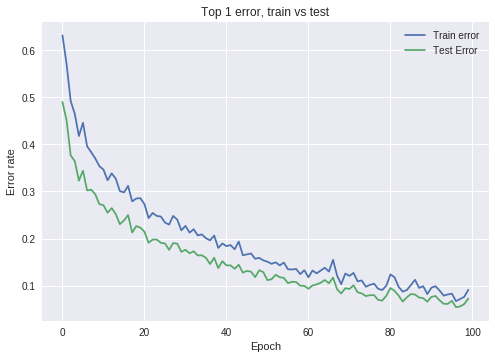

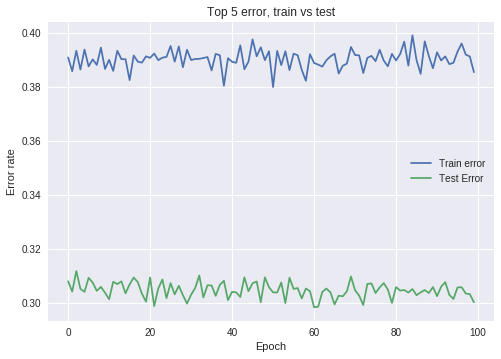

No handles with labels found to put in legend.


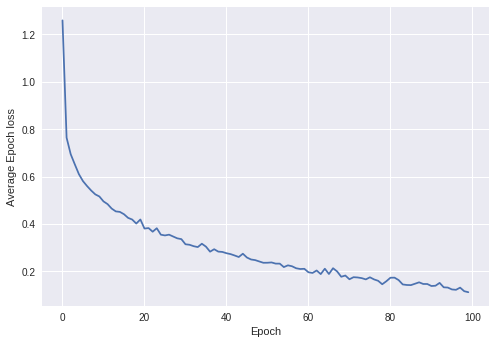

In [34]:
#Train model 
cnn2_avg_loss, cnn2_top1_error_train, cnn2_top5_error_train, cnn2_top1_error_test, cnn2_top5_error_test= CNN2_arch_train()



# CNN Architecture 3: Inspiration from GoogleNet Inception Modules

**Design Considerations**

The third CNN architecture augmented the basic CNN architecture with inspiration from GoogleNet´s Inception Modules.First it used one ordinary convolutional layer followed by a maxpool layer, then a deeper convolutional layer. In the middle convolutional layers, the signal was split between convolution modules with different kernels.   The idea was to apply these different kernels to capture patterns at different scales, such as done in GoogleNet´s Inception modules (Géron, 2017 p.375). The considerations of increasing filter depth from AlexNet was carried through in the increasing filter depths from convolutional layer 1, convolutional layer 2 and the parallell layers. 

Because of time constraints, the third CNN idea remained on a conceptual stage. 


---
**CNN Architecture 3**
---
| Layers | Type | Maps| Size | Kernel Size | Stride | Activation |
| --- | --- | --- | --- |  --- |  --- | --- |
| Out | Fully connected | - | 10 | - | - | - |
| Hidden 2 | Fully connected | - | 1000 | - | - | ReLU |
| Hidden 1 | Fully connected | - | 1000 | - | - | ReLU |
| || | In Parallell ||   ||
| Conv7_conv | Convolution | 128| 32x32 | 1x1 | -| ReLU |
| Conv6_conv | Convolution | 128| 32x32 | 1x1 | - | ReLU |
| Conv5_conv | Convolution | 128| 32x32 | 5x5 | - | ReLU |
| Conv4_conv | Convolution | 128| 32x32 | 3x3 | - | ReLU |
| || | In Sequence ||   ||
| Conv3_conv | Convolution | 128| 32x32 | 5x5 | 1 | ReLU |
| Conv2_conv | Convolution | 64| 32x32 | 5x5 | 1 | ReLU |
| Conv1_maxpool | Maxpool | 32| 32x32 | 2x2 | 2 | - |
| Conv1_conv | Convolution | 32| 32x32 | 5x5 | 1 | ReLU |


### Performance Comparison of CNN1 and CNN2

In [35]:
def comp_losses_cnn():
  plt.title("Comparison of Avg Epoch Losses of CNN1 and CNN2")
  plt.xlabel("Epoch")
  plt.ylabel("Average Epoch loss")
  plt.plot(cnn1_avg_loss, label = "Average Loss CNN1")
  plt.plot(cnn2_avg_loss, label = "Average Loss CNN2")
  plt.legend()
  plt.show()

def comp_top1_errors():
  plt.title("Comparison of Top 1 error rates of CNN1 and CNN2")         
  plt.ylabel('Top1 Error rates')
  plt.xlabel('Epoch')
  plt.plot(cnn1_top1_error_train,label = "Top 1 Error Training Data CNN1")
  plt.plot(cnn2_top1_error_train,label = "Top 1 Error Training Data CNN2")
  plt.plot(cnn1_top1_error_test, label ="Top 1 Error Test Data CNN1")
  plt.plot(cnn2_top1_error_test,label = "Top 1 Error Test Data CNN2")
  plt.legend()
  plt.show()

  

def comp_top5_errors():
  plt.title("Comparison of Top 5 error rates of CNN1 and CNN2")         
  plt.ylabel('Top5 Error rates')
  plt.xlabel('Epoch')
  plt.plot(cnn1_top5_error_train, label ="Top 5 Error Training Data CNN1")
  plt.plot(cnn2_top5_error_train, label ="Top 5 Error Training Data CNN2")
  plt.plot(cnn1_top5_error_test, label ="Top 5 Error Test Data CNN1")
  plt.plot(cnn2_top5_error_test, label ="Top 5 Error Test Data CNN2")
  plt.legend()
  plt.show()

print("CNN1 Final Average Loss", cnn1_avg_loss[-1],"CNN2 Final Average Loss", cnn2_avg_loss[-1],)

CNN1 Final Average Loss 0.14437830448150635 CNN2 Final Average Loss 0.1122513860464096


## Discussion and Presentation of Results of CNN1 and CNN2

**Model Performance Statistics **

- ***CNN Architecture 1: Simple Variation of Basic CNN***

  - Final Average Epoch Loss:  0.14437830448150635 
  - Top 1 error on training data  0.10040283
  - Top 1 error on test data 0.07940674 
  - Top 5 error on training data 0.0.39434814
  - Top 5 error on test datta 0.0.3005371
  



 - ***CNN Architecture 2: Variation Inspired by AlexNet ***

  - Final Average Epoch Loss 0.1122513860464096
  - Top 1 error on training data  0.09112549 
  - Top 1 error on test data 0.072509766 
  - Top 5 error on train training data 0.38537598
  - Top 5 errors on test data 0.30029297


**Loss rate Comparison**

CNN Architecture 1 (CNN1) had a final average epoch loss of 0.20438392460346222 while CNN Architecture 2(CNN2) has a final average epoch loss of  0.13211500644683838. Examining the loss rates of the two models, reveals that the average loss rate of CNN2 was constitently below that of CNN1. This would suggest that the increased filter depth of CNN2 compared to CNN1, as well as the feature of directly sequential convolutional layers, had a positive impact on the model loss rate. 

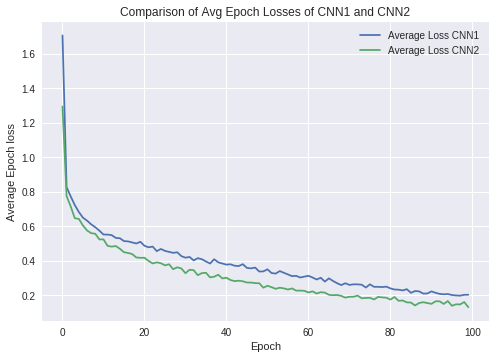

In [0]:
comp_losses_cnn()

**Error Rate Comparison**


Examining the Top 5 Error rates and Top 1 Error rates of the two models reveal that, discounting stochastic movements, validation  performances of the two models on the training and test data is largely similar. 

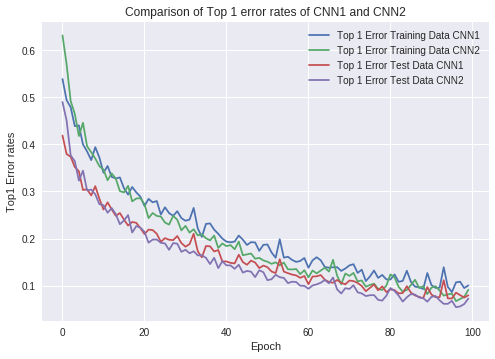

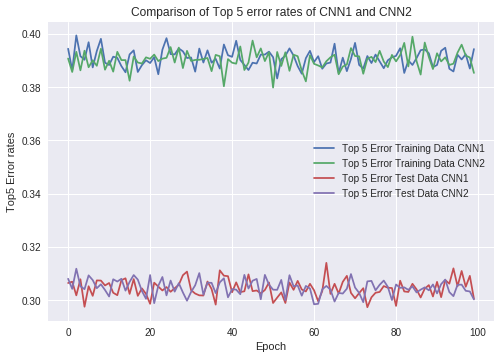

In [37]:
comp_top1_errors()
comp_top5_errors()

## CNN Architecture 1 + 2: Deeper variation combining CNN1 and CNN2

Based on the observed similarity in performance of CNN1 and CNN2, a fourth Architecture was conceived that combined the convolution and maxpool layers from the CNN1 with the  increased filter depth and  subsequent convolution layers of CNN2. The overall filter depth was also increased throughout the network in order to attempt capturing more features from the picture data, and an extra layer was added to the CNN2 convolutional layers. 

---
**CNN Architecture 1+2**

---
| Layers | Type | Maps| Size | Kernel Size | Stride | Activation |
| --- | --- | --- | --- |  --- |  --- | --- |
| Out | Fully connected | - | 10 | - | - | - |
| Hidden 2 | Fully connected | - | 1000 | - | - | ReLU |
| Hidden 1 | Fully connected | - | 1000 | - | - | ReLU |
|  | |  | Increased CNN2 features|   |   |  |
| Conv8_conv | Convolution | 128| 32x32 | 5x5 | 1 | ReLU |
| Conv7_conv | Convolution | 192| 32x32 | 5x5 | 1 | ReLU |
| Conv6_conv | Convolution | 256| 32x32 | 5x5 | 1 | ReLU |
| Conv5_conv | Convolution | 256| 32x32 | 5x5 | 1 | ReLU |
|  | |  | Increased CNN1 features|   |   |  |
| Conv4_maxpool | Maxpool | 192| 32x32 | 2x2 | 2 | - |
| Conv4_conv | Convolution | 192| 32x32 | 5x5 | 1 | ReLU |
| Conv3_maxpool | Maxpool | 128| 32x32 | 2x2 | 2 | - |
| Conv3_conv | Convolution | 128| 32x32 | 5x5 | 1 | ReLU |
| Conv2_maxpool | Maxpool | 64| 32x32 | 2x2 | 2 | - |
| Conv2_conv | Convolution | 64| 32x32 | 5x5 | 1 | ReLU |
| Conv1_maxpool | Maxpool | 32| 32x32 | 2x2 | 2 | - |
| Conv1_conv | Convolution | 32| 32x32 | 5x5 | 1 | ReLU |
| --- | --- | --- | --- |  --- |  --- | --- |



In [0]:
 
# Deeper variation of Convolutional Neural Network 
def deeper_variation_CNN12(data_train):  #cnn_minibatch_size

    
    with tf.variable_scope('full_cnn', reuse = tf.AUTO_REUSE):
        
        
        #Convolutional layer 1   - channels!
        with tf.name_scope("Convolutional_layer_1") as scope: 
            conv_layer1_conv_sublayer = tf.layers.conv2d(data_train, filters = 32, kernel_size = 5 , strides = 1, padding = "same", activation = tf.nn.relu, name = "conv1")
            conv_layer1_maxp_sublayer = tf.layers.max_pooling2d(inputs = conv_layer1_conv_sublayer, pool_size = [2,2] , strides = 2, name = "maxpool1")

        #Convolutional layer 2 -Same, but with conv1 input
        with tf.name_scope("Convolutional_layer_2") as scope: 
            conv_layer2_conv_sublayer = tf.layers.conv2d(conv_layer1_maxp_sublayer, filters = 64, kernel_size = 5, strides = 1,padding = "same",  activation = tf.nn.relu, name = "conv2")
            conv_layer2_maxp_sublayer = tf.layers.max_pooling2d(inputs = conv_layer2_conv_sublayer, pool_size = [2,2] , strides = 2, name = "maxpool2")

        #Convolutional layer 3
        with tf.name_scope("Convolutional_layer_3") as scope: 
            conv_layer3_conv_sublayer = tf.layers.conv2d(conv_layer2_maxp_sublayer, filters = 128, kernel_size = 5 , strides = 1,padding = "same",  activation = tf.nn.relu, name = "conv3")
            conv_layer3_maxp_sublayer = tf.layers.max_pooling2d(inputs = conv_layer3_conv_sublayer, pool_size = [2,2] , strides = 2, name = "maxpool3")

        #Convolutional layer 4
        with tf.name_scope("Convolutional_layer_4") as scope: 
            conv_layer4_conv_sublayer = tf.layers.conv2d(conv_layer3_maxp_sublayer, filters = 192, kernel_size = 5 , strides = 1,padding = "same",  activation = tf.nn.relu, name = "conv4")
            conv_layer4_maxp_sublayer = tf.layers.max_pooling2d(inputs = conv_layer4_conv_sublayer, pool_size = [2,2] , strides = 2, name = "maxpool4")

            
        #Conv5, C6, C7, C8: Sequential Convolutional Layers
        with tf.name_scope("Sequential_convolutional_layers") as scope: 
            conv_layer5_conv_sublayer = tf.layers.conv2d(conv_layer4_maxp_sublayer, filters = 256, kernel_size = 5 , strides = 1,padding = "same",  activation = tf.nn.relu, name = "conv5")
            conv_layer6_conv_sublayer = tf.layers.conv2d(conv_layer5_conv_sublayer, filters = 256, kernel_size = 5 , strides = 1,padding = "same",  activation = tf.nn.relu, name = "conv6")
            conv_layer7_conv_sublayer = tf.layers.conv2d(conv_layer6_conv_sublayer, filters = 192, kernel_size = 5 , strides = 1,padding = "same",  activation = tf.nn.relu, name = "conv7")
            conv_layer8_conv_sublayer = tf.layers.conv2d(conv_layer6_conv_sublayer, filters = 128, kernel_size = 5 , strides = 1,padding = "same",  activation = tf.nn.relu, name = "conv8")
            

        #Flattening inputs for dense layer  - [batch_size, 32,32,3]
        conv_flat = tf.reshape(conv_layer8_conv_sublayer, [-1, 128*2*2 ], name = "flattening")
        
        with tf.name_scope("Hidden_Layers") as scope: 
          #Hidden Layer 1: Hidden fully connected layer of 1000 units
          hidden_layer_1 = tf.layers.dense( inputs =  conv_flat, units = 1024, activation = tf.nn.relu, name = "hidden_layer_1")

          #Hidden Layer 1: Hidden fully connected layer of 1000 units
          hidden_layer_2 = tf.layers.dense( inputs =  hidden_layer_1, units = 1024, activation = tf.nn.relu, name = "hidden_layer_2")
 
        #Output Layer 
        with tf.name_scope("Outputs") as scope: 
            outputs = tf.layers.dense(inputs = hidden_layer_2, units = n_classes, activation = None, name = "outputs")

    return outputs 
  
  
  

In [16]:
#Redo setup 

#Import Libraries

   
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
np.random.seed(1)
from datetime import datetime as dt
import datetime
from datetime import datetime

#Get the Data and Explore 

from keras.datasets import cifar10
(data_train, label_train), (data_test, label_test) = cifar10.load_data()

#Shape 10,000x32x32x3 
#Classes: 10
#Conv2D: [batch_size, height, width, channels]
#Batch purposes: [batch_size, 32, 32, 3]

#Explore shape of Data 
#print(data_train[0].shape)
data_height = 32
data_width = 32
channels = 3

#def default_CNN_setup():  #cnn_specific_outputs cnn_model
#Reset Graph
tf.reset_default_graph()

#Find number of different classes in data 
n_classes = int(max(label_train) - min(label_train) + 1)
#print(n_classes)
class_min = int(min(label_train))

#Find shape of labels
print(data_train.shape)

print(len(data_train), len(data_test))
#print(label_train[0:10])

#Unpack label_train data to reduce dimensionality for one_hot transform
label_train_unpackall = np.array([])
for i in range(len(label_train)):
    label_train_unpackall = np.append(label_train_unpackall, label_train.item(i))
    
label_test_unpackall = np.array([])
for i in range(len(label_test)):
    label_test_unpackall = np.append(label_test_unpackall, label_test.item(i))
    
    #if i %10000 == 0 :
    #    print(i)
    
with tf.Session() as sess: 
  label_train_all_onehot = tf.cast(tf.one_hot(label_train_unpackall, n_classes), tf.float32).eval()
  label_test_all_onehot = tf.cast(tf.one_hot(label_test_unpackall, n_classes), tf.float32).eval()
  
  label_train_all_onehot_2 = tf.one_hot(label_train , n_classes).eval()

  
#print(len(label_train_unpackall))

#Transform Labels to one hot
#label_train_onehot_all = tf.one_hot(label_train_unpackall, n_classes)

#Define Setup for Variables and Parameters  which are Independent of CNN Architecture 


  
#Set HyperParameters
cnn_minibatch_size = 128
cnn_learning_rate = 0.001 
cnn_total_n_epochs = 100

n_minibatches = int(len(data_train)/cnn_minibatch_size)


#Create Placeholders for Data
with tf.variable_scope('placeholders') as scope: 
    X = tf.placeholder(tf.float32, [50000, 32,32,3], name = "X")
    y = tf.placeholder(tf.float32, [50000, n_classes], name = "y")  # cnn_minibatch_size
    y_labels = tf.argmax(y, axis=1)  # From Lecture 4, Homework example 


#Create Placeholders for Train error  Data
with tf.variable_scope('placeholders') as scope: 
    X_train = tf.placeholder(tf.float32, [50000, 32,32,3], name = "X_train")
    y_train = tf.placeholder(tf.float32, [50000, n_classes], name = "y_train")  # cnn_minibatch_size
    y_labels_train = tf.argmax(y_train, axis=1)  # From Lecture 4, Homework example 


    #Create Placeholders for Test Data
with tf.variable_scope('placeholders') as scope: 
    X_test = tf.placeholder(tf.float32, [10000, 32,32,3], name = "X_test")
    y_test = tf.placeholder(tf.float32, [10000, n_classes], name = "y_test")  # cnn_minibatch_size
    y_labels_test = tf.argmax(y_test, axis=1)  # From Lecture 4, Homework example 

    
#Define Dataset shuffle 

data_set = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(n_minibatches*cnn_minibatch_size, reshuffle_each_iteration = False).batch(cnn_minibatch_size)

iterator = data_set.make_initializable_iterator()

x_batch, y_batch = iterator.get_next()


#Define Dataset batch handling for training set error

data_set_train = tf.data.Dataset.from_tensor_slices((X_train, y_train, y_labels_train)).shuffle(n_minibatches*cnn_minibatch_size, reshuffle_each_iteration = False).batch(cnn_minibatch_size) # #shuffle(n_minibatches*cnn_minibatch_size, reshuffle_each_iteration = False)
iterator_train = data_set_train.make_initializable_iterator()
x_batch_train, y_batch_train, y_batch_labels_train = iterator_train.get_next()



#Define Dataset batch handling for test set

data_set_test = tf.data.Dataset.from_tensor_slices((X_test, y_test, y_labels_test)).batch(cnn_minibatch_size)  #shuffle
iterator_test = data_set_test.make_initializable_iterator()
x_batch_test, y_batch_test, y_batch_labels_test = iterator_test.get_next()


#Define Outputs 

outputs = deeper_variation_CNN12(x_batch)     #output_string
outputs_train = deeper_variation_CNN12(x_batch_train)  
outputs_test = deeper_variation_CNN12(x_batch_test)


  
#Define Loss Function    
with tf.name_scope("loss") as scope: 
  loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_batch, logits = outputs, name = "cross_entropy_loss"))
  loss_sum_v = tf.Variable(0.0, dtype = tf.float32)
  loss_tozero = loss_sum_v.assign(0.0)
  loss_add = loss_sum_v.assign_add(loss)        
    
  loss_average = tf.divide(loss_sum_v, tf.constant(128.0, dtype= tf.float32)) 

#Define Optimisers

#Mini-batch gradient descent 
optimiser_gd_cnn=tf.train.GradientDescentOptimizer(learning_rate=cnn_learning_rate) 

#Mini-batch AdaGrad (Géron, 2017 p.300)
   
optimiser_ag_cnn = tf.train.AdagradOptimizer(learning_rate =cnn_learning_rate)  

#Mini-batch gradient descent with Nesterov´s momentum (Géron, 2017 p.299)

optimiser_n_cnn = tf.train.MomentumOptimizer(learning_rate =cnn_learning_rate , momentum = 0.9, use_nesterov = True) 
    
#Mini-batch Adam (Géron, 2017 p.302)
    
optimiser_adm_cnn = tf.train.AdamOptimizer(learning_rate =cnn_learning_rate ) 
    
    
# Error rate code based on Evaluation in Géron (2017, p.271)
    
with tf.name_scope("Top_1_Error"):
    top1_errors = (tf.subtract(tf.constant(1, dtype= tf.int32), tf.cast(tf.nn.in_top_k(outputs_train,tf.cast(y_batch_labels_train , tf.int32), 1),tf.int32)))  #tf.arg_max(, dimension = 1)
    top1_error_rate = tf.reduce_mean(tf.cast(top1_errors, tf.float32))
        
with tf.name_scope("Top_5_Error"):
  top5_errors = tf.subtract(tf.constant(1), tf.cast(tf.nn.in_top_k(outputs, tf.cast(y_batch_labels_train , tf.int32), 5), tf.int32)) # , tf.arg_max dimension = 1)
  top5_error_rate = tf.reduce_mean(tf.cast(top5_errors, tf.float32))

with tf.name_scope("Top_1_Error_test"):
    top1_errors_test = (tf.subtract(tf.constant(1, dtype= tf.int32), tf.cast(tf.nn.in_top_k(outputs_test,tf.cast(y_batch_labels_test , tf.int32), 1),tf.int32)))  #tf.arg_max(, dimension = 1)
    top1_error_rate_test = tf.reduce_mean(tf.cast(top1_errors, tf.float32))
        
with tf.name_scope("Top_5_Error_test"):
  top5_errors_test = tf.subtract(tf.constant(1), tf.cast(tf.nn.in_top_k(outputs_test, tf.cast(y_batch_labels_test , tf.int32), 5), tf.int32)) # , tf.arg_max dimension = 1)
  top5_error_rate_test = tf.reduce_mean(tf.cast(top5_errors, tf.float32))          
    
   
#Define training error sum variables
top1_train_sum = tf.Variable(0.0, dtype= tf.float32)
top5_train_sum = tf.Variable(0.0, dtype= tf.float32)
top1_test_sum = tf.Variable(0.0, dtype= tf.float32)
top5_test_sum = tf.Variable(0.0, dtype= tf.float32)
           
#Define functions setting error sum variables to zero
top1_train_sum_tozero = top1_train_sum.assign(0.0)
top5_train_sum_tozero = top5_train_sum.assign(0.0)
top1_test_sum_tozero = top1_test_sum.assign(0.0)
top5_test_sum_tozero = top5_test_sum.assign(0.0)
            
#Define Functions adding the current error to sum variable
top1_train_sum_add = top1_train_sum.assign_add(top1_error_rate)
top5_train_sum_add = top5_train_sum.assign_add(top5_error_rate)
top1_test_sum_add = top1_test_sum.assign_add(top1_error_rate_test)
top5_test_sum_add = top5_test_sum.assign_add(top5_error_rate_test)
            
            
#Define function averaging error rates per epoch
top1_train_epoch_avg = tf.divide(top1_train_sum, tf.constant(128.0, dtype= tf.float32))
top5_train_epoch_avg = tf.divide(top5_train_sum, tf.constant(128.0, dtype= tf.float32))
top1_test_epoch_avg =  tf.divide(top1_test_sum, tf.constant(128.0, dtype= tf.float32))
top5_test_epoch_avg =  tf.divide(top5_test_sum, tf.constant(128.0, dtype= tf.float32))


#Define function plotting avg loss per epoch 
def plot_avg_epoch_loss(avg_loss_epoch_list):
  plt.plot(avg_loss_epoch_list)
  plt.xlabel("Epoch")
  plt.ylabel("Average Epoch loss")
  plt.legend()
  plt.show() 
     
  #Define Error plot function 
    
def plot_train_test_error(error_train, error_test, title): 
  plt.plot(error_train, label = 'Train error' )
  plt.plot(error_test, label = 'Test Error')
  plt.ylabel('Error rate')
  plt.xlabel('Epoch')
  plt.title(title)
  plt.legend()
  plt.show()
    

#Save all parametres to disk
saver = tf.train.Saver()


#Define Default CNN Training Function 
def CNN12_arch_train():
    
    with tf.Session() as sess: 
      
        #Define training operation 
        #Using Adam Optimiser with Default value as suggested by Géron (2017 p.303)

        optimiser=optimiser_adm_cnn
        cnn_train_op=optimiser.minimize(loss)
        
        
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        tf.initialize_all_variables().run()
        
        #cnn_loss_list = np.array([])
        cnn_avg_loss_epoch_list = np.array([])
        cnn_top1_error_train = np.array([])
        cnn_top5_error_train = np.array([])
        cnn_top1_error_test = np.array([])
        cnn_top5_error_test = np.array([])
       

        #Define array for shuffling in each epoch 
        reference_array = tf.range(n_minibatches)

        #Train CNN by iterating through epochs
        for epoch in range(0,100): 
            
            if (epoch+1)%10==0:
              print("starting epoch", epoch)
            epoch_start_time = dt.now()

            #Reset all Error estimates to zero, start of batch 
            sess.run(iterator.initializer, feed_dict = {X:data_train ,y:label_train_all_onehot}) 


            #ReSet Loss variable to zero 
            sess.run([loss_tozero, top1_train_sum_tozero, top5_train_sum_tozero, top1_test_sum_tozero, top5_test_sum_tozero])
            
            # Iterate through first 50 mini-batches for one epoch training
            for batch in range (0,50):

                #Run the session on the next minibatch -  
                _, l, la = sess.run([ cnn_train_op, loss, loss_add]) 
                

            #Add Avg Epoch loss to list
            avg_epoch_loss = loss_average.eval()
            cnn_avg_loss_epoch_list = np.append(cnn_avg_loss_epoch_list, avg_epoch_loss) #(sum(cnn_loss_list[0+cnn_minibatch_size*epoch:cnn_minibatch_size+cnn_minibatch_size*epoch]))/cnn_minibatch_size)
            
            if (epoch+1)%10==0:
              print("epoch loss", avg_epoch_loss)
                       
            #Evaluate Training and Test set error rates for the current epoch 
           
            #Initialize Iterator with training data for error evaluation 
            sess.run(iterator_train.initializer, feed_dict = {X_train: data_train , y_train:label_train_all_onehot})  
            
            #Evaluate on Training Set
            for batch_n in range(0,100):               

              top1_train_batch, top5_train_batch, t1_tr , t2_tr = sess.run([top1_error_rate, top5_error_rate, top1_train_sum_add, top5_train_sum_add]) # feed_dict = {X: data_train , y: label_train_all_onehot})
              
              
            #Initialize Iterator with test data for error evaluation 
            sess.run(iterator_test.initializer, feed_dict = {X_test: data_test , y_test: label_test_all_onehot})  
            #print("initalized test")
             
            #Evaluate on Test set   
            for batch_nn in range(0,78): 
              top1_test_batch, top5_test_batch, t1_te, t2_te = sess.run([top1_error_rate_test, top1_error_rate_test, top1_test_sum_add, top5_test_sum_add ]) #, feed_dict = {X_test: data_test , y_test: label_test_all_onehot})
                        
            
            #Add average epoch error to the Avg Error lists

            #Evaluate the error rate variables at the end of epoch
            cnn_top1_error_train_epoch = top1_train_epoch_avg.eval()
            cnn_top5_error_train_epoch = top5_train_epoch_avg.eval()
            cnn_top1_error_test_epoch =  top1_test_epoch_avg.eval()
            cnn_top5_error_test_epoch =  top5_test_epoch_avg.eval()          
            
            cnn_top1_error_train = np.append(cnn_top1_error_train , cnn_top1_error_train_epoch)
            cnn_top5_error_train = np.append(cnn_top5_error_train, cnn_top5_error_train_epoch)
            cnn_top1_error_test = np.append(cnn_top1_error_test,  cnn_top1_error_test_epoch)
            cnn_top5_error_test = np.append(cnn_top5_error_test, cnn_top5_error_test_epoch)

            
            if (epoch+1)%10==0:
              print("Errors Epoch nr ", epoch, "Top 1 error: train ", cnn_top1_error_train_epoch, "test",cnn_top1_error_test_epoch,'\n', 
                  "Top 5 error: train", cnn_top5_error_train_epoch, "test",cnn_top5_error_test_epoch)
            
            if (epoch+1) %10 == 0:
              #Take the time of each epoch 
              epoch_endtime = str(dt.now())
              #epoch_duration = str(datetime.timedelta(epoch_start_time, epoch_endtime))
              print("ended epoch:", epoch, "endtime", epoch_endtime ) # "duration:", epoch_duration)
              
              save_string ="/"+str(epoch)+"cnn1.ckpt"
              save_patch = saver.save(sess, save_string)
              
        #Plot top 1 and top 5 error rates
        try: 
          plot_train_test_error(cnn_top1_error_train, cnn_top1_error_test, "Top 1 error, train vs test")
          plot_train_test_error(cnn_top5_error_train, cnn_top5_error_test, "Top 5 error, train vs test")

        except: 
          print("Error plots unsuccessfull")
          
        #Plot Avg Epoch Loss
        try:
          plot_avg_epoch_loss(cnn_avg_loss_epoch_list)
        
        except: 
          print("Loss plots unsuccessfull")
        
        #Save model 
        try:
          save_patch = saver.save(sess, "/CNN.ckpt")
        except:
          print("Save unsuccessfull")
        
    return cnn_avg_loss_epoch_list, cnn_top1_error_train, cnn_top5_error_train, cnn_top1_error_test, cnn_top5_error_test
        
        
  


(50000, 32, 32, 3)
50000 10000


starting epoch 9
epoch loss 0.5734594
Errors Epoch nr  9 Top 1 error: train  0.44018555 test 0.3421631 
 Top 5 error: train 0.38824463 test 0.30529785
ended epoch: 9 endtime 2019-02-27 12:08:35.058749
starting epoch 19
epoch loss 0.41807854
Errors Epoch nr  19 Top 1 error: train  0.29040527 test 0.2286377 
 Top 5 error: train 0.39178467 test 0.30786133
ended epoch: 19 endtime 2019-02-27 12:10:06.682951
starting epoch 29
epoch loss 0.34920654
Errors Epoch nr  29 Top 1 error: train  0.25177002 test 0.19244385 
 Top 5 error: train 0.38568115 test 0.30419922
ended epoch: 29 endtime 2019-02-27 12:11:38.316488
starting epoch 39
epoch loss 0.29778633
Errors Epoch nr  39 Top 1 error: train  0.20196533 test 0.15667725 
 Top 5 error: train 0.38830566 test 0.3067627
ended epoch: 39 endtime 2019-02-27 12:13:10.373063
starting epoch 49
epoch loss 0.23834452
Errors Epoch nr  49 Top 1 error: train  0.15112305 test 0.1204834 
 Top 5 error: train 0.39672852 test 0.31085205
ended epoch: 49 endtime 2019-

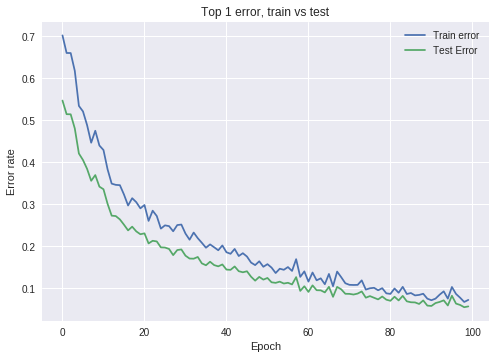

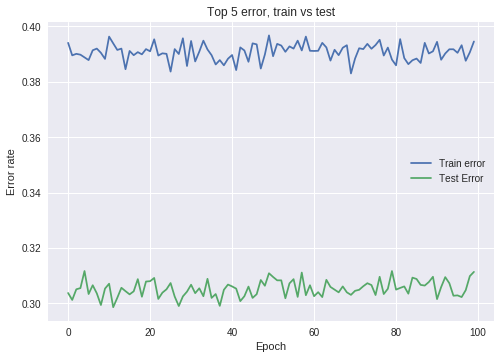

No handles with labels found to put in legend.


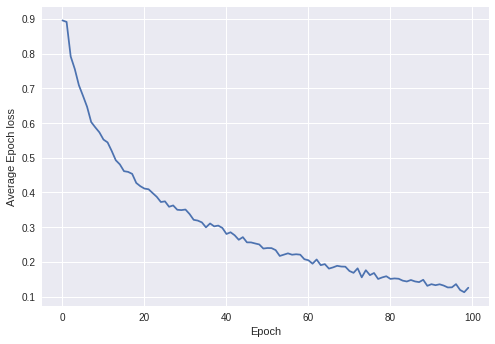

In [17]:
cnn12_avg_loss, cnn12_top1_error_train, cnn12_top5_error_train, cnn12_top1_error_test, cnn12_top5_error_test= CNN12_arch_train()

## Discussion and Presentation of Results of CNN1 and CNN2

**Performance Statistics Summary**


---
| Model  | Final Avg. Epoch Loss | Top 1 error train data | Top 1 error test  data | Top 5 error train data  |  Top 5 error test data |
| --- | --- | --- | --- |  --- |  --- | --- |
|CNN Architecture 1 | 0.14437830448150635  | 0.10040283|   0.07940674 |   0.39434814| 0.3005371|
|CNN Architecture 2 |0.1122513860464096| 0.09112549|   0.072509766  |    0.38537598|  0.30029297|
|CNN Architecture 1+2 | 0.12536108493804932  |0.072143555 |  0.056640625 |   0.39453125| 0.31134033|






**Loss rate Comparison**

Examining the average loss per epoch for the three models, the CNN1+2 model converges somewhat slower during the first 20 epochs of training. This is of course to be expected, considering the increased depth of the network. From Epoch 60 untill end of training, the CNN1+2 model losses are less than the ones for CNN1, but almost identical to the CNN2 losses. 

**Error rate Comparison**

The somewhat slower convergence of CNN1+2 applies also to the Top1 losses, again as a consequence of the increased depth of the network. Between Epochs 60 and 100, the Top 1 errors for CNN1+2 also follow the errors for the CNN2 very closely. The final Top 1 error loss on the test data for CNN1+2 is, 0.0566, while this error is 0.0725 for CNN2. This would suggest the CNN1+2 performed better than the CNN2, which in turn performed better than CNN1. However, examning the Top 1 Error graph makes this more nuanced as one can observe that the CNN2 error drops below the CNN1+2 error just a few epochs before end of training. The CNN2 error also spikes slighly right before end of training. This would suggest that the error difference between CNN2 and CNN1+2 are not necessarily significant. The architectural difference between CNN2 and CNN1+2 were the addition of one more combined convolution-maxpool layer, another convolutional layer in the convolution layer sequence, and increased filter depths. The performances would suggest that these changes do not make significant performance differences on the models, at least not for the current dataset. 

One can observe that the CNN1 has consistently larger errors than both CNN2 and CNN1+2 from around epoch 50 and onwards.  The main difference between the CNN1 architecture and the CNN2 and CNN1+2 architectures is the use of directly sequential deep convolutional layers. This suggests the addition of such subsequent deep convolutional layers is an architectural feature that can positively impact model performance. Overall, this validates the position of the literature stemmning from the pinoeering of this method by AlexNet (Géron, 2017 p.373). 

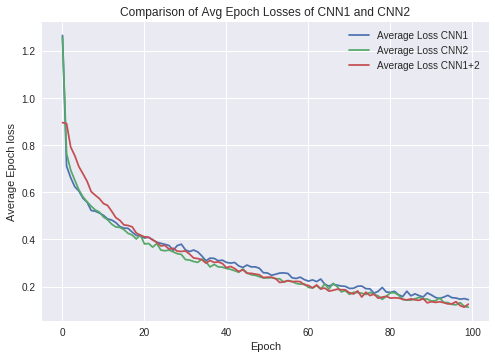

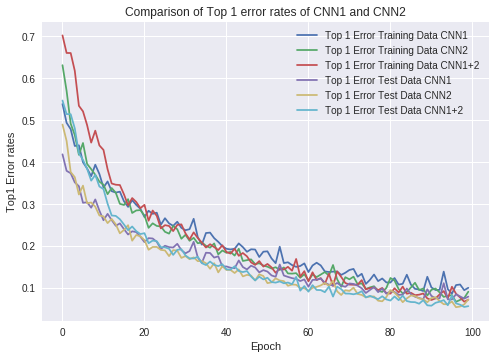

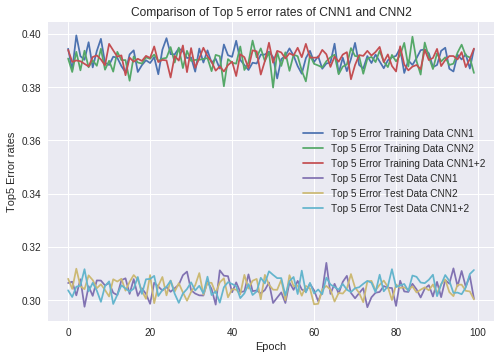

In [42]:
comp_losses_cnn1_2_12()
comp_top1_errors1_2_12()
comp_top5_errors1_2_12()

In [0]:
def comp_losses_cnn1_2_12():
  plt.title("Comparison of Avg Epoch Losses of CNN1 and CNN2")
  plt.xlabel("Epoch")
  plt.ylabel("Average Epoch loss")
  plt.plot(cnn1_avg_loss, label = "Average Loss CNN1")
  plt.plot(cnn2_avg_loss, label = "Average Loss CNN2")
  plt.plot(cnn12_avg_loss, label = "Average Loss CNN1+2")
  plt.legend()
  plt.show()

def comp_top1_errors1_2_12():
  plt.title("Comparison of Top 1 error rates of CNN1 and CNN2")         
  plt.ylabel('Top1 Error rates')
  plt.xlabel('Epoch')
  plt.plot(cnn1_top1_error_train,label = "Top 1 Error Training Data CNN1")
  plt.plot(cnn2_top1_error_train,label = "Top 1 Error Training Data CNN2")
  plt.plot(cnn12_top1_error_train,label = "Top 1 Error Training Data CNN1+2")
  plt.plot(cnn1_top1_error_test, label ="Top 1 Error Test Data CNN1")
  plt.plot(cnn2_top1_error_test,label = "Top 1 Error Test Data CNN2")
  plt.plot(cnn12_top1_error_test,label = "Top 1 Error Test Data CNN1+2")
  plt.legend()
  plt.show()

  

def comp_top5_errors1_2_12():
  plt.title("Comparison of Top 5 error rates of CNN1 and CNN2")         
  plt.ylabel('Top5 Error rates')
  plt.xlabel('Epoch')
  plt.plot(cnn1_top5_error_train, label ="Top 5 Error Training Data CNN1")
  plt.plot(cnn2_top5_error_train, label ="Top 5 Error Training Data CNN2")
  plt.plot(cnn12_top5_error_train, label ="Top 5 Error Training Data CNN1+2")
  plt.plot(cnn1_top5_error_test, label ="Top 5 Error Test Data CNN1")
  plt.plot(cnn2_top5_error_test, label ="Top 5 Error Test Data CNN2")
  plt.plot(cnn12_top5_error_test, label ="Top 5 Error Test Data CNN1+2")
  plt.legend()
  plt.show()

In [43]:
cnn12_avg_loss[-1]

0.12536108493804932

# References

Géron, A (2017) *Hands-On Machine Learning with Sci-kit Learn and Tensorflow*.  O´Reilly Media Inc, Sebastopol 

Goodfellow, I., Bengio, Y. and Courville, A. (2016) *Deep Learning*.  MIT Press, London England